In [1]:
import os 
import sys 
import h5py 
import numpy as np 
import corner as DFM 
# -- galpopfm --
from galpopfm import dustfm as dustFM
from galpopfm import dust_infer as dustInfer
from galpopfm import measure_obs as measureObs
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [2]:
dat_dir = os.environ['GALPOPFM_DIR']

In [3]:
#########################################################################
# read in SDSS measurements
#########################################################################
r_edges, gr_edges, fn_edges, _ = dustInfer.sumstat_obs(name='sdss',
        statistic='2d', return_bins=True)
dr  = r_edges[1] - r_edges[0]
dgr = gr_edges[1] - gr_edges[0]
dfn = fn_edges[1] - fn_edges[0]
ranges = [(r_edges[0], r_edges[-1]), (-0.05, 1.5), (-1., 4.)]

fsdss = os.path.join(dat_dir, 'obs', 'tinker_SDSS_centrals_M9.7.valueadd.hdf5') 
sdss = h5py.File(fsdss, 'r') 

mr_complete = (sdss['mr_tinker'][...] < -20.)

x_obs = [-1.*sdss['mr_tinker'][...][mr_complete], 
        sdss['mg_tinker'][...][mr_complete] - sdss['mr_tinker'][...][mr_complete], 
        sdss['ABSMAG'][...][:,0][mr_complete] - sdss['ABSMAG'][...][:,1][mr_complete]] 

In [7]:
def _sim_observables(sim, theta): 
    ''' read specified simulations and return data vector 
    '''
    _sim_sed = dustInfer._read_sed(sim) 
    wlim = (_sim_sed['wave'] > 1e3) & (_sim_sed['wave'] < 8e3) 
    #downsample = np.zeros(len(_sim_sed['logmstar'])).astype(bool)
    #downsample[::10] = True
    downsample = np.ones(len(_sim_sed['logmstar'])).astype(bool)
    f_downsample = 1.#0.1
    cens = _sim_sed['censat'].astype(bool) & (_sim_sed['logmstar'] > 9.4) & downsample

    sim_sed = {} 
    sim_sed['sim']          = sim 
    sim_sed['logmstar']     = _sim_sed['logmstar'][cens].copy()
    sim_sed['logsfr.inst']  = _sim_sed['logsfr.inst'][cens].copy() 
    sim_sed['logsfr.100']   = _sim_sed['logsfr.100'][cens].copy() 
    sim_sed['wave']         = _sim_sed['wave'][wlim].copy()
    sim_sed['sed_noneb']    = _sim_sed['sed_noneb'][cens,:][:,wlim].copy() 
    sim_sed['sed_onlyneb']  = _sim_sed['sed_onlyneb'][cens,:][:,wlim].copy() 

    x_mod = dustInfer.sumstat_model(theta, sed=sim_sed,
            dem='slab_noll_msfr', f_downsample=f_downsample, statistic='2d',
            return_datavector=True)
    return x_mod, sim_sed

In [8]:
#########################################################################
# read in simulations without dust attenuation
#########################################################################
x_simba, simba = _sim_observables('simba', np.array([0. for i in range(9)]))

In [12]:
zero_sfr100 = simba['logsfr.100'] == -999
print('%i of %i galaxies with 0 SFR_100Myr' % (np.sum(zero_sfr100), len(zero_sfr100)))
zero_sfrinst = simba['logsfr.inst'] == -999
print('%i of %i galaxies with 0 SFR_inst' % (np.sum(zero_sfrinst), len(zero_sfrinst)))

6291 of 17717 galaxies with 0 SFR_100Myr
1755 of 17717 galaxies with 0 SFR_inst


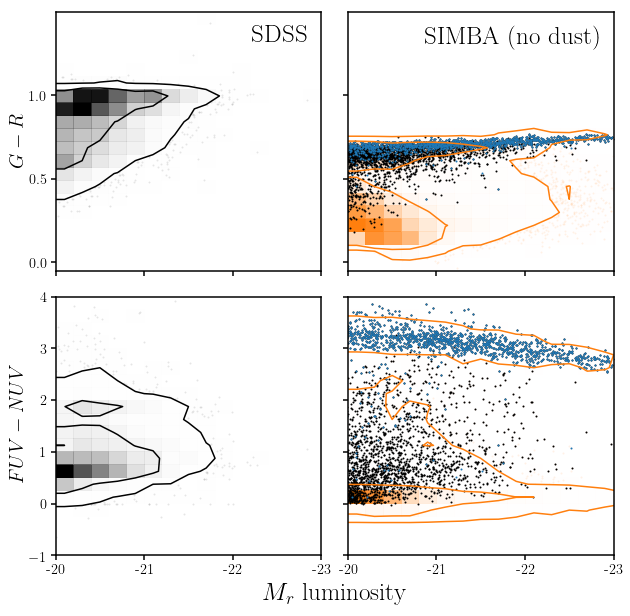

In [13]:
xs      = [x_obs, x_simba]
names   = ['SDSS', 'SIMBA (no dust)']
clrs    = ['k', 'C1']

fig = plt.figure(figsize=(5*len(xs),10))

# R vs (G - R)
for i, _x, name, clr in zip(range(len(xs)), xs, names, clrs): 
    sub = fig.add_subplot(2,len(xs),i+1)
    #sub.pcolormesh(r_edges, gr_edges, _x[1].T,
    #        vmin=1e-5, vmax=1e-2, norm=mpl.colors.LogNorm(), cmap=clr)
    DFM.hist2d(_x[0], _x[1], levels=[0.68, 0.95],
            range=[ranges[0], ranges[1]], bins=20, color=clrs[i], 
            plot_datapoints=True, fill_contours=False, plot_density=True, ax=sub)
    
    if name != 'SDSS': 
        sub.scatter(_x[0][zero_sfr100], _x[1][zero_sfr100], c='k', s=1)
        sub.scatter(_x[0][zero_sfrinst], _x[1][zero_sfrinst], c='C0', s=1)

    sub.text(0.95, 0.95, name, ha='right', va='top', transform=sub.transAxes, fontsize=25)
    sub.set_xlim(20., 23) 
    sub.set_xticks([20., 21., 22., 23]) 
    sub.set_xticklabels([])
    if i == 0: 
        sub.set_ylabel(r'$G-R$', fontsize=20) 
    else: 
        sub.set_yticklabels([]) 
    sub.set_ylim(ranges[1]) 
    sub.set_yticks([0., 0.5, 1.])

# R vs FUV-NUV
for i, _x, name, clr in zip(range(len(xs)), xs, names, clrs): 
    sub = fig.add_subplot(2,len(xs),i+len(xs)+1)
    #h = sub.pcolormesh(r_edges, fn_edges, _x[2].T,
    #        vmin=1e-5, vmax=1e-2, norm=mpl.colors.LogNorm(), cmap=clr)
    DFM.hist2d(_x[0], _x[2], levels=[0.68, 0.95],
            range=[ranges[0], ranges[2]], bins=20, color=clrs[i], 
            plot_datapoints=True, fill_contours=False, plot_density=True, ax=sub) 
    
    if name != 'SDSS': 
        sub.scatter(_x[0][zero_sfr100], _x[2][zero_sfr100], c='k', s=1)
        sub.scatter(_x[0][zero_sfrinst], _x[2][zero_sfrinst], c='C0', s=1)

    sub.set_xlim(20., 23) 
    sub.set_xticks([20., 21., 22., 23]) 
    sub.set_xticklabels([-20, -21, -22, -23]) 
    if i == 0: 
        sub.set_ylabel(r'$FUV - NUV$', fontsize=20) 
    else: 
        sub.set_yticklabels([]) 
    sub.set_ylim(ranges[2]) 

bkgd = fig.add_subplot(111, frameon=False)
bkgd.set_xlabel(r'$M_r$ luminosity', labelpad=10, fontsize=25) 
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
fig.subplots_adjust(wspace=0.1, hspace=0.1)

What happens if we remove the SFRinst = 0 galaxies?

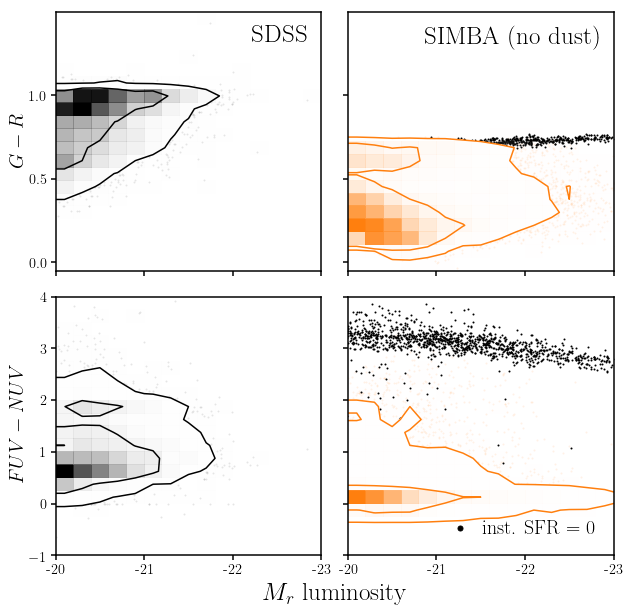

In [17]:
xs      = [x_obs, x_simba]
names   = ['SDSS', 'SIMBA (no dust)']
clrs    = ['k', 'C1']

fig = plt.figure(figsize=(5*len(xs),10))

# R vs (G - R)
for i, _x, name, clr in zip(range(len(xs)), xs, names, clrs): 
    sub = fig.add_subplot(2,len(xs),i+1)
    if name == 'SDSS': 
        DFM.hist2d(_x[0], _x[1], levels=[0.68, 0.95],
            range=[ranges[0], ranges[1]], bins=20, color=clrs[i], 
            plot_datapoints=True, fill_contours=False, plot_density=True, ax=sub)
    else:
        sub.scatter(_x[0][zero_sfrinst], _x[1][zero_sfrinst], c='k', s=1)
        DFM.hist2d(_x[0][~zero_sfrinst], _x[1][~zero_sfrinst], levels=[0.68, 0.95],
                   range=[ranges[0], ranges[1]], bins=20, color=clrs[i], 
                   plot_datapoints=True, fill_contours=False, plot_density=True, ax=sub)

    sub.text(0.95, 0.95, name, ha='right', va='top', transform=sub.transAxes, fontsize=25)
    sub.set_xlim(20., 23) 
    sub.set_xticks([20., 21., 22., 23]) 
    sub.set_xticklabels([])
    if i == 0: 
        sub.set_ylabel(r'$G-R$', fontsize=20) 
    else: 
        sub.set_yticklabels([]) 
    sub.set_ylim(ranges[1]) 
    sub.set_yticks([0., 0.5, 1.])

# R vs FUV-NUV
for i, _x, name, clr in zip(range(len(xs)), xs, names, clrs): 
    sub = fig.add_subplot(2,len(xs),i+len(xs)+1)
    
    if name == 'SDSS':  
        DFM.hist2d(_x[0], _x[2], levels=[0.68, 0.95],
            range=[ranges[0], ranges[2]], bins=20, color=clrs[i], 
            plot_datapoints=True, fill_contours=False, plot_density=True, ax=sub) 
    else:
        sub.scatter(_x[0][zero_sfrinst], _x[2][zero_sfrinst], c='k', s=1, label='inst. SFR = 0')
        DFM.hist2d(_x[0][~zero_sfrinst], _x[2][~zero_sfrinst], levels=[0.68, 0.95],
            range=[ranges[0], ranges[2]], bins=20, color=clrs[i], 
            plot_datapoints=True, fill_contours=False, plot_density=True, ax=sub) 
        sub.legend(loc='lower right', handletextpad=0.1, markerscale=5, fontsize=20)
    sub.set_xlim(20., 23) 
    sub.set_xticks([20., 21., 22., 23]) 
    sub.set_xticklabels([-20, -21, -22, -23]) 
    if i == 0: 
        sub.set_ylabel(r'$FUV - NUV$', fontsize=20) 
    else: 
        sub.set_yticklabels([]) 
    sub.set_ylim(ranges[2]) 

bkgd = fig.add_subplot(111, frameon=False)
bkgd.set_xlabel(r'$M_r$ luminosity', labelpad=10, fontsize=25) 
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
fig.subplots_adjust(wspace=0.1, hspace=0.1)

the SFR_inst = 0 population has a very distinct imprint on the observables: e.g. they are tightly clustered in the color-magnitude space. Even with attenuation, these galaxies will be clustered in the observable space and affect the distance. 